In [2]:
# ====================================================== required libs
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# ====================================================== visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline

rcParams['figure.figsize'] = 16,8

# ====================================================== preprocessing
from sklearn.preprocessing import MinMaxScaler

# ====================================================== model
import torch
from torch import nn, optim

# ====================================================== parameters

RANDOM_SEED = 1642
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [90]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080'

In [20]:
data = pd.read_csv('d:/Projects/datasets/daily_weather.csv')
data.head()

,DateTime,Temperature
0,2009-01-01,-6.810629
1,2009-01-02,-3.360486
2,2009-01-03,5.435694
3,2009-01-04,7.283889
4,2009-01-05,12.690069


In [21]:
data.shape

(2923, 2)

In [22]:
data.isna().sum()

DateTime       0
Temperature    2
dtype: int64

In [23]:
data.ffill(inplace=True)


In [24]:
data.DateTime = pd.to_datetime(data.DateTime, format='%Y-%m-%d')

data.set_index('DateTime', inplace=True)

In [25]:
data.head()

,Temperature
DateTime,
2009-01-01,-6.810629
2009-01-02,-3.360486
2009-01-03,5.435694
2009-01-04,7.283889
2009-01-05,12.690069


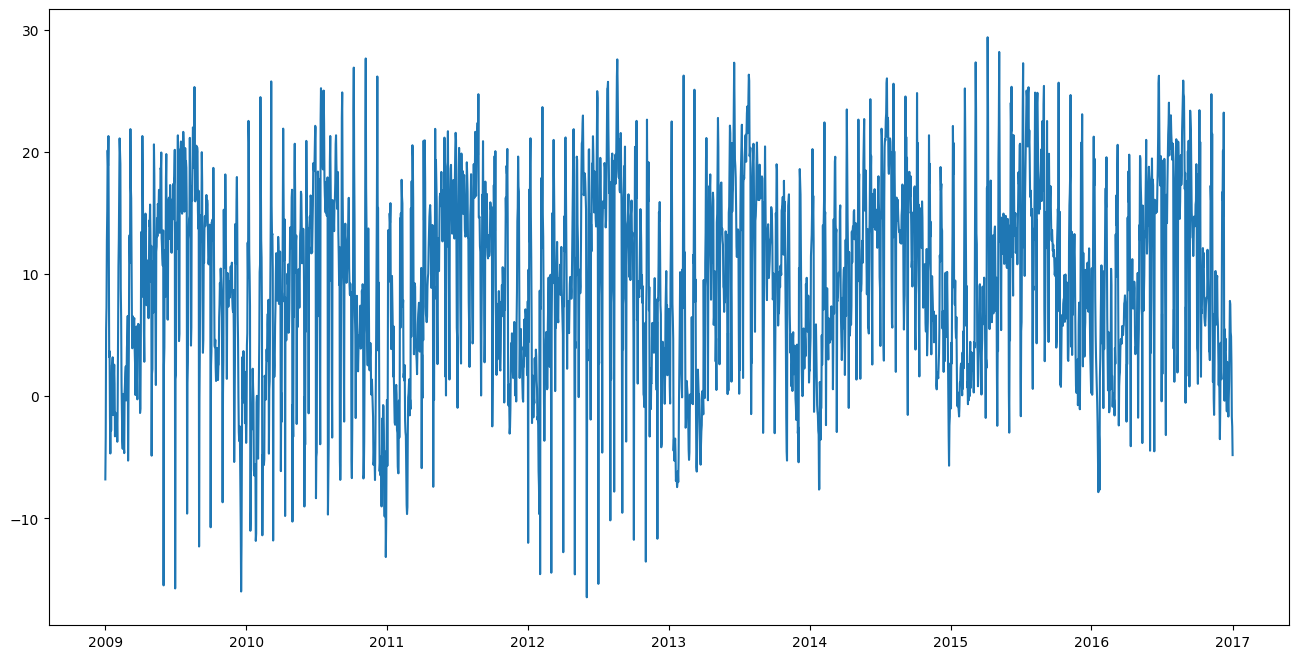

In [27]:
plt.plot(data['Temperature'])

In [45]:
# differencing

df = data.diff().fillna(data[:1]).astype(np.float64)
df.head()

,Temperature
DateTime,
2009-01-01,-6.810629
2009-01-02,3.450143
2009-01-03,8.796181
2009-01-04,1.848194
2009-01-05,5.406181


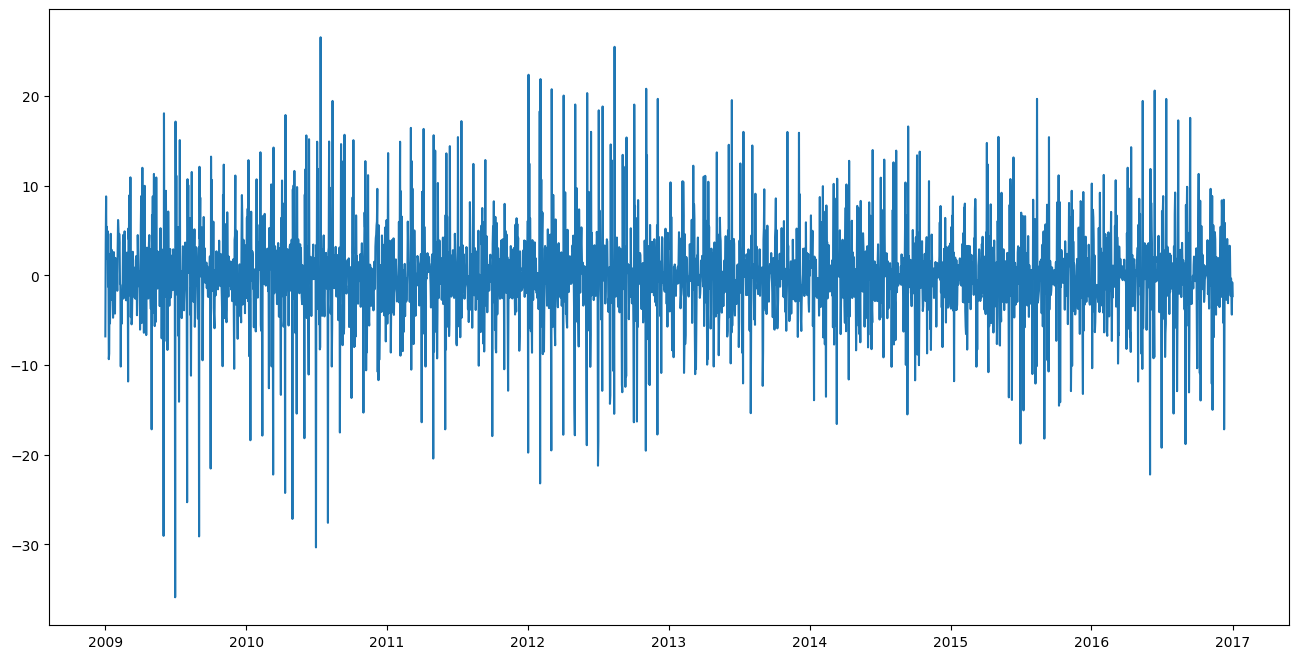

In [46]:
plt.plot(df['Temperature'])

In [48]:
len(df)

2923

In [53]:
test_data= 0.2 * len(df)

train = df[:-int(test_data)]
test = df[-int(test_data):]

print(train.shape)
print(test.shape)

(2339, 1)
(584, 1)


In [57]:
#scaling the dataset

scaler = MinMaxScaler()

scaler = scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

In [58]:
def create_seq(data, seq_len):
    
    xs = []
    ys = []
    
    for i in range(len(data)-seq_len-1):
        
        x = data[i:(i+seq_len)]
        y = data[i+seq_len]
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

In [59]:
seq_len = 7

X_train, y_train = create_seq(train, seq_len)
X_test, y_test = create_seq(test, seq_len)

In [60]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [61]:
X_train.shape

torch.Size([2331, 7, 1])

In [63]:
X_train[:3]

tensor([[[0.4659],
         [0.6302],
         [0.7159],
         [0.6046],
         [0.6616],
         [0.6152],
         [0.6538]],

        [[0.6302],
         [0.7159],
         [0.6046],
         [0.6616],
         [0.6152],
         [0.6538],
         [0.5548]],

        [[0.7159],
         [0.6046],
         [0.6616],
         [0.6152],
         [0.6538],
         [0.5548],
         [0.6138]]])

In [78]:
# model building

class temp_prediction(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(temp_prediction, self).__init__()
        
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers = n_layers,
            dropout = 0.5  
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hs(self):
        
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    
    def forward(self, sequence):
        lstm_out, self.hidden = self.lstm(
            sequence.view(len(sequence), self.seq_len, -1),
            self.hidden
        )
        last_ts = lstm_out.view(self.seq_len, len(sequence), self.n_hidden)[-1]
        y_pred = self.linear(last_ts)
        return y_pred

In [87]:
# model training

def model_training(model,train_data, train_labels, test_data=None, test_labels=None):
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 80
    
    hist_train = np.zeros(num_epochs)
    hist_test = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        
        model.reset_hs()
        
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            hist_test[t] = test_loss.item()
            
            if t%10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
            elif t%10 == 0:
                print(f'Epoch {t} train loss: {loss.item()}')
            
            hist_train[t] = loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return model.eval(), hist_train, hist_test

In [88]:
model = temp_prediction(
    n_features=1,
    n_hidden=512,
    seq_len=seq_len,
    n_layers=3
)

In [89]:
model, hist_train, hist_test = model_training(model, X_train, y_train,
                                              X_test, y_test)

Epoch 0 train loss: 748.4959716796875 test loss: 184.70034790039062
Epoch 10 train loss: 342.6193542480469 test loss: 84.23676300048828
Epoch 20 train loss: 111.1767807006836 test loss: 28.307756423950195
Epoch 30 train loss: 39.696014404296875 test loss: 9.342805862426758
Epoch 40 train loss: 23.792640686035156 test loss: 5.829634189605713
Epoch 50 train loss: 20.79300880432129 test loss: 4.804585933685303
Epoch 60 train loss: 19.35978889465332 test loss: 4.635049819946289
Epoch 70 train loss: 19.296537399291992 test loss: 4.4787445068359375


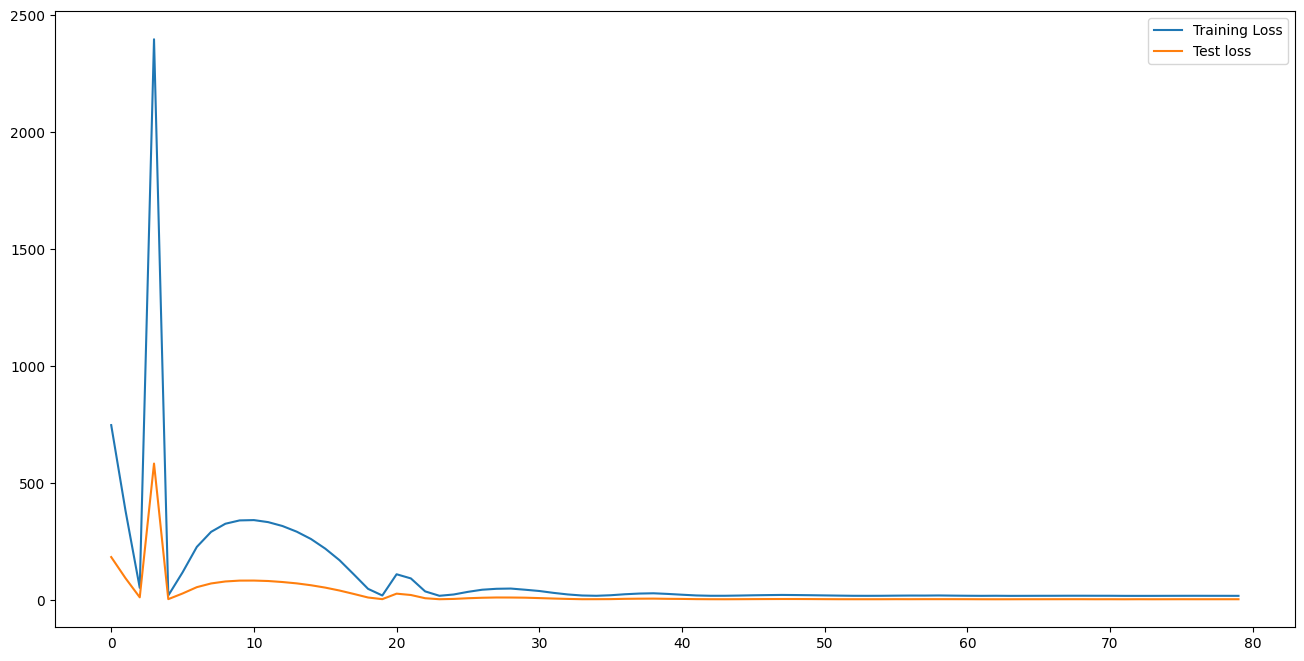

In [91]:
plt.plot(hist_train, label='Training Loss')
plt.plot(hist_test, label = 'Test loss')
plt.legend()

In [92]:
with torch.no_grad():
    test_seq = X_test[:1]
    preds=[]
    
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_len, 1).float()

In [93]:
temps = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

In [94]:
pred_temps = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
).flatten()

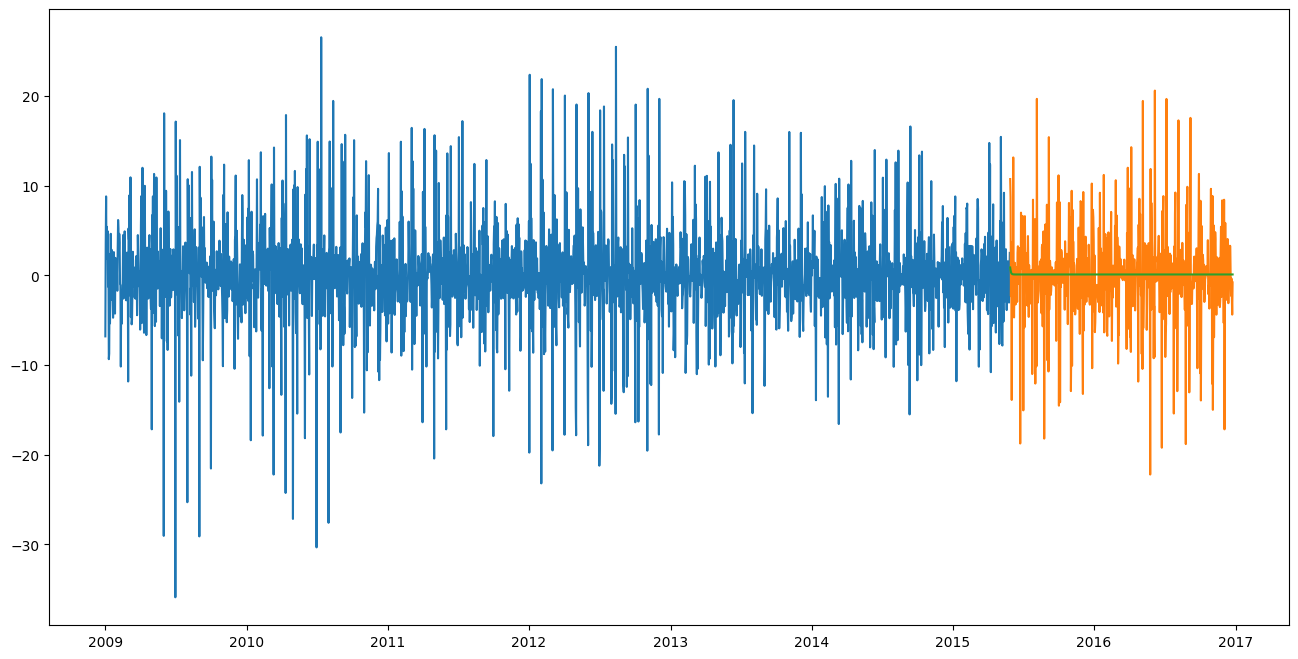

In [95]:
plt.plot(
    df.index[:len(train)],
    scaler.inverse_transform(train).flatten(),
    label = 'Historical Temperature'
)

plt.plot(
    df.index[len(train):len(train)+len(temps)],
    temps,
    label = 'Occured Temp'
)

plt.plot(
    df.index[len(train):len(train)+len(temps)],
    pred_temps,
    label = 'Occured Temp'
)